# Import

In [83]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
import torch.nn as nn
from torch.functional import F
import torchvision.transforms as T
from torchvision import models
from torchvision.utils import make_grid
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from minisom import MiniSom

# Data load

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("apollo2506/eurosat-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/mihalko711/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6


In [6]:
img_path = os.path.join(path, "EuroSAT")

# Dataet

In [7]:
class EuroSATDataset(Dataset):
    def __init__(self, csv_path, image_root, return_label=False):
        self.df = pl.read_csv(csv_path).drop(pl.read_csv(csv_path).columns[0])
        self.image_root = Path(image_root)
        self.return_label = return_label

        self.transform = T.Compose([
            T.Resize((64, 64)),  # Гарантируем размер 64x64
            T.ToTensor(),        # Переводит [0, 255] -> [0.0, 1.0]
            T.Normalize(
                mean=[0.5, 0.5, 0.5], # (x - 0.5) / 0.5
                std=[0.5, 0.5, 0.5]   # Результат: [-1.0, 1.0]
            )
        ])

    def __len__(self):
        return self.df.height

    def __getitem__(self, idx):
        row = self.df.row(idx, named=True)

        img_path = self.image_root / row["Filename"]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        if self.return_label:
            return image, row["Label"], row["ClassName"]

        return image

torch.Size([3, 64, 64])


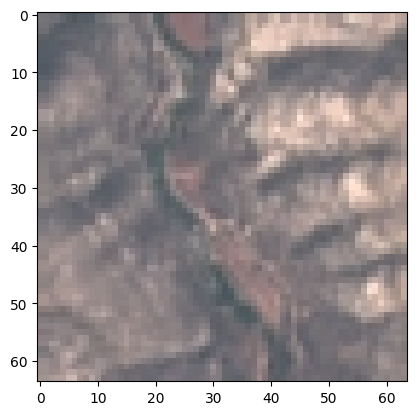

In [24]:
dataset = EuroSATDataset(
    csv_path=os.path.join(img_path, "train.csv"),
    image_root=os.path.join(img_path),
    return_label=True
)

idx = np.random.randint(len(dataset))

x, label, name = dataset[idx]
print(x.shape)
plt.imshow(x.permute(1, 2, 0) * 0.5 + 0.5)

# Model class

In [49]:
class TopoResNet(nn.Module):
    def __init__(self, num_classes=10, embedding_dim=64, pretrained=True):
        super().__init__()
        
        # 1. КАК ЗАГРУЗИТЬ RESNET
        # Используем веса ImageNet (DEFAULT)
        weights = models.ResNet18_Weights.DEFAULT if pretrained else None
        self.backbone = models.resnet18(weights=weights)
        
        # 2. КАК ОТКРУТИТЬ ГОЛОВУ
        # У ResNet голова хранится в атрибуте .fc (Fully Connected)
        # Входная размерность стандартной головы (обычно 512 для ResNet18)
        num_features = self.backbone.fc.in_features
        
        # Удаляем родную голову, заменяя ее на "пустышку" (Identity), 
        # чтобы мы могли сами контролировать поток данных после пулинга
        self.backbone.fc = nn.Identity()
        
        # 3. КАК ДОКРУТИТЬ СВОЮ ГОЛОВУ (Projection Head)
        
        # Слой a) Сжатие в эмбеддинг (для SOM)
        # Это то самое "узкое горлышко"
        self.projection = nn.Sequential(
            nn.Linear(num_features, 256), # Промежуточный слой
            nn.ReLU(),
            nn.Linear(256, embedding_dim) # Итоговый эмбеддинг (например, 64)
        )
        
        # Слой b) Классификатор (нужен ТОЛЬКО для обучения)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, x, return_embedding=False):
        # Прогон через ResNet (без старой головы)
        # На выходе тензор (B, 512)
        features = self.backbone(x)
        
        # Сжимаем в эмбеддинг (B, 64)
        embedding = self.projection(features)
        
        # Если мы просто хотим получить вектор для SOM (после обучения)
        if return_embedding:
            return embedding
        
        # Классификация (B, 10) - для обучения
        logits = self.classifier(embedding)
        return logits, embedding

    def save_weights(self, path: str):
        """
        Сохраняет веса модели в файл.
        """
        os.makedirs(os.path.dirname(path), exist_ok=True)

        torch.save(
            {
                "model_state_dict": self.state_dict(),
                "num_classes": self.classifier.out_features,
                "embedding_dim": self.projection[-1].out_features,
            },
            path
        )

    def load_weights(self, path: str, map_location="cpu"):
        """
        Загружает веса модели из файла.
        """
        checkpoint = torch.load(path, map_location=map_location)
        self.load_state_dict(checkpoint["model_state_dict"])



def base_train_loop(model, criterion, optimizer, train_loader, test_loader, epochs):
    epoch_loop = tqdm(range(epochs), desc="Итерации по эпохам", leave=False)
    history = {
        "train_loss": [],
        "test_loss": [],
        'train_acc': [],
        "test_acc": []
    }
    for epoch in epoch_loop:
        model.train()
        train_total_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch in tqdm(train_loader, desc="Итерация по батчам(трейн)", leave=False):
            if isinstance(batch, (list, tuple)):
                imgs = batch[0].to(device)
                labels = batch[1].to(device)
            else:
                raise ValueError("Для Fine-tuning нужны метки классов!")
    
            optimizer.zero_grad()
            
            logits, _ = model(imgs)
            
            loss = criterion(logits, labels)
            
            loss.backward()
            optimizer.step()
            
            train_total_loss += loss.item()
            
            # Точность (Accuracy)
            _, predicted = torch.max(logits.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        model.eval()
        test_total_loss = 0
        test_correct = 0
        test_total = 0
        for batch in tqdm(test_loader, desc="Итерация по батчам(тест)", leave=False):
            if isinstance(batch, (list, tuple)):
                imgs = batch[0].to(device)
                labels = batch[1].to(device)
            else:
                raise ValueError("Для Fine-tuning нужны метки классов!")
    
            with torch.no_grad():
                logits, _ = model(imgs)
                loss = criterion(logits, labels)
            
            test_total_loss += loss.item()
            

            _, predicted = torch.max(logits.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
        
        
            
        epoch_loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        epoch_loop.set_postfix(
            train_loss=train_total_loss/len(train_loader),
            train_acc=train_correct/train_total,
            test_loss=test_total_loss/len(test_loader),
            test_acc=test_correct/test_total
        )

        history['train_loss'].append(train_total_loss/len(train_loader))
        history['train_acc'].append(train_correct/train_total)
        history['test_loss'].append(test_total_loss/len(test_loader))
        history['test_acc'].append(test_correct/test_total)

    return model, history

In [111]:
train_ds = EuroSATDataset(
    csv_path=os.path.join(img_path, "train.csv"),
    image_root=os.path.join(img_path),
    return_label=True
)

val_ds = EuroSATDataset(
    csv_path=os.path.join(img_path, "validation.csv"),
    image_root=os.path.join(img_path),
    return_label=True
)

test_ds = EuroSATDataset(
    csv_path=os.path.join(img_path, "test.csv"),
    image_root=os.path.join(img_path),
    return_label=True
)

In [112]:
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

In [40]:
# Настройки
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TopoResNet(num_classes=10, embedding_dim=64).to(device)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 10

model, history = base_train_loop(model, criterion, optimizer, train_loader, val_loader, epochs)
# модель уже обучена и в памяти
model.save_weights("../checkpoints/toporesnet.pth")

Итерации по эпохам:   0%|          | 0/10 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

In [61]:
model = TopoResNet(num_classes=10, embedding_dim=64)
model.load_weights("../checkpoints/toporesnet.pth")
model.to(device)
model.eval()


/tmp/ipykernel_70123/1471162964.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=map_location)


TopoResNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

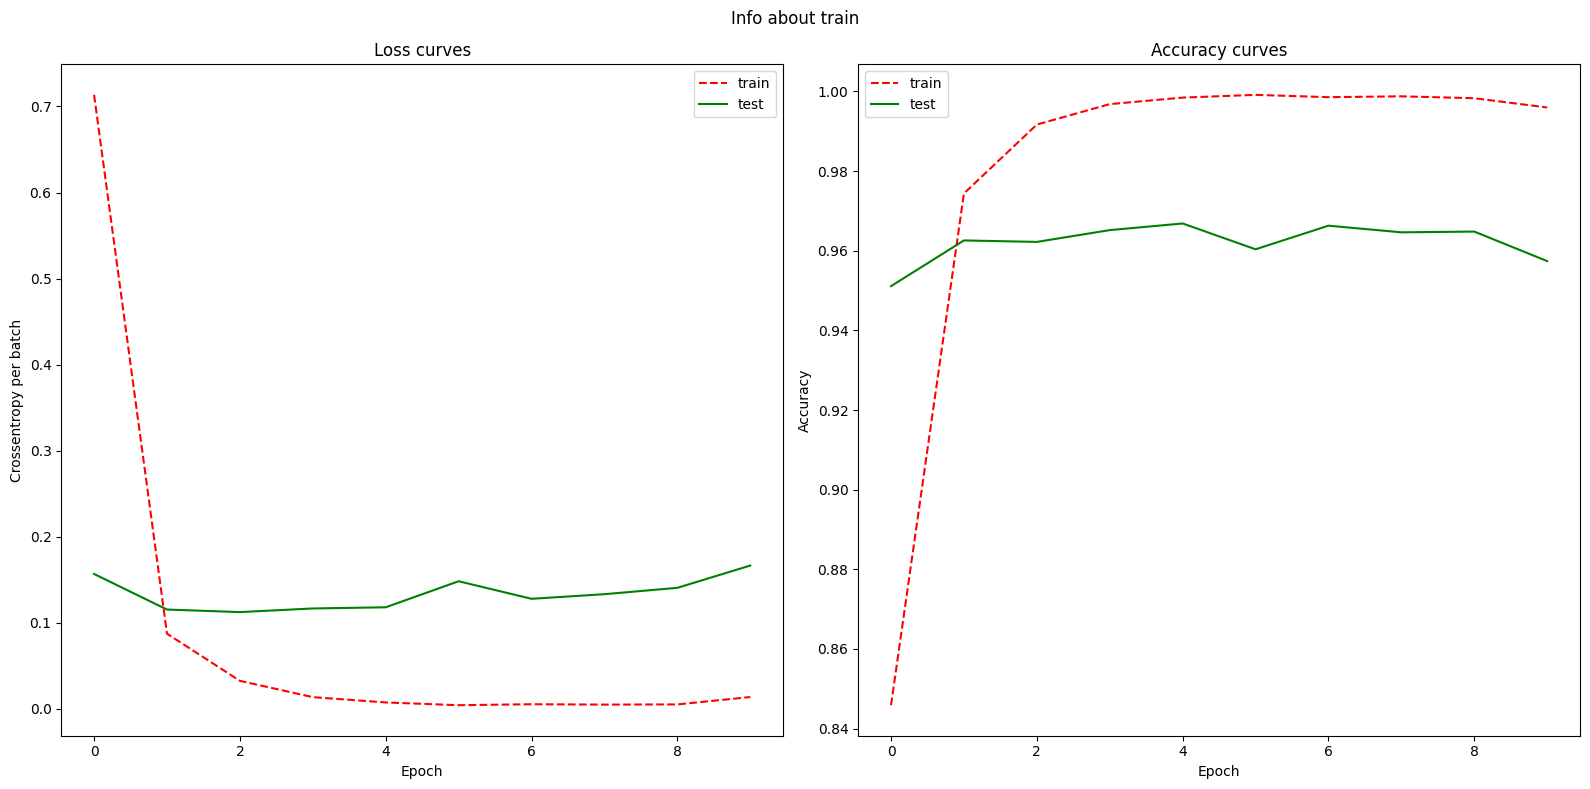

In [47]:
fig = plt.figure(figsize=(16, 8))

ax_loss = fig.add_subplot(1, 2, 1)
ax_loss.plot(history['train_loss'], c='red', ls='--', label='train')
ax_loss.plot(history['test_loss'], c='green', label='test')
ax_loss.set(title='Loss curves', xlabel='Epoch', ylabel='Crossentropy per batch')
ax_loss.legend()

ax_accuracy = fig.add_subplot(1, 2, 2)
ax_accuracy.plot(history['train_acc'], c='red', ls='--', label='train')
ax_accuracy.plot(history['test_acc'], c='green', label='test')
ax_accuracy.set(title='Accuracy curves', xlabel='Epoch', ylabel='Accuracy')
ax_accuracy.legend()

fig.suptitle('Info about train')
fig.tight_layout()

# MiniSom

In [114]:
with torch.no_grad():
    embedding_lst = []
    label_lst = []
    for batch in tqdm(train_loader, desc='Генерация эмбеддингов(трейн)'):
        if isinstance(batch, (list, tuple)):
                imgs = batch[0].to(device)
                labels = batch[1].to(device)
        else:
            raise ValueError("Для Fine-tuning нужны метки классов!")
        embeddings = model(imgs, return_embedding=True).cpu().numpy()
        embedding_lst.append(embeddings)
        label_lst.append(labels.cpu().numpy())

    embeddings_train = np.concatenate(embedding_lst, axis=0)
    labels_train = np.concatenate(label_lst, axis=0)

    embedding_lst = []
    label_lst = []
    for batch in tqdm(test_loader, desc='Генерация эмбеддингов(тест)'):
        if isinstance(batch, (list, tuple)):
                imgs = batch[0].to(device)
                labels = batch[1].to(device)
        else:
            raise ValueError("Для Fine-tuning нужны метки классов!")
        embeddings = model(imgs, return_embedding=True).cpu().numpy()
        embedding_lst.append(embeddings)
        label_lst.append(labels.cpu().numpy())

    embeddings_test = np.concatenate(embedding_lst, axis=0)
    labels_test = np.concatenate(label_lst, axis=0)

# 2. обучаем SOM
som = MiniSom(50, 50,
              embeddings_train.shape[1],
              sigma=1.0,
              learning_rate=0.5)

som.random_weights_init(embeddings_train)
som.train(embeddings_train, 10000)

# 3. сохраняем SOM
np.save("../checkpoints/som.npy", som.get_weights())


Генерация эмбеддингов(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Генерация эмбеддингов(тест):   0%|          | 0/11 [00:00<?, ?it/s]

In [115]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from matplotlib.patches import Patch

def plot_som_legend_full(som, embeddings, labels, class_names=None, save_path=None):
    """
    Визуализирует SOM:
    - цифры классов в ячейках
    - легенда с форматом "цифра - имя класса", цвет совпадает с текстом
    """
    plt.figure(figsize=(8, 8))
    wmap = {}

    # собираем метки по нейронам
    for x, t in zip(embeddings, labels):
        w = som.winner(x)
        if w in wmap:
            wmap[w].append(t)
        else:
            wmap[w] = [t]

    # рисуем текст для нейронов
    for (x, y), class_list in wmap.items():
        most_common = Counter(class_list).most_common(1)[0][0]
        color = plt.cm.rainbow(most_common / max(labels))
        plt.text(x + 0.5, y + 0.5, str(most_common),
                 color=color,
                 fontdict={'weight': 'bold', 'size': 11},
                 ha='center', va='center')

    plt.axis([0, som.get_weights().shape[0], 0, som.get_weights().shape[1]])
    plt.title("SOM: наиболее частые классы")
    plt.xticks([])
    plt.yticks([])

    # легенда
    if class_names is not None:
        # если исходный словарь вида {"cat":0}, инвертируем
        if all(isinstance(k, str) for k in class_names.keys()):
            inv_class_names = {v: k for k, v in class_names.items()}
        else:
            inv_class_names = class_names

        legend_elements = [
            Patch(facecolor=plt.cm.rainbow(k / max(labels)),
                  label=f"{k} - {inv_class_names[k]}")
            for k in sorted(inv_class_names)
        ]
        plt.legend(handles=legend_elements, loc=[1.0, 0.25], fontsize=10)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


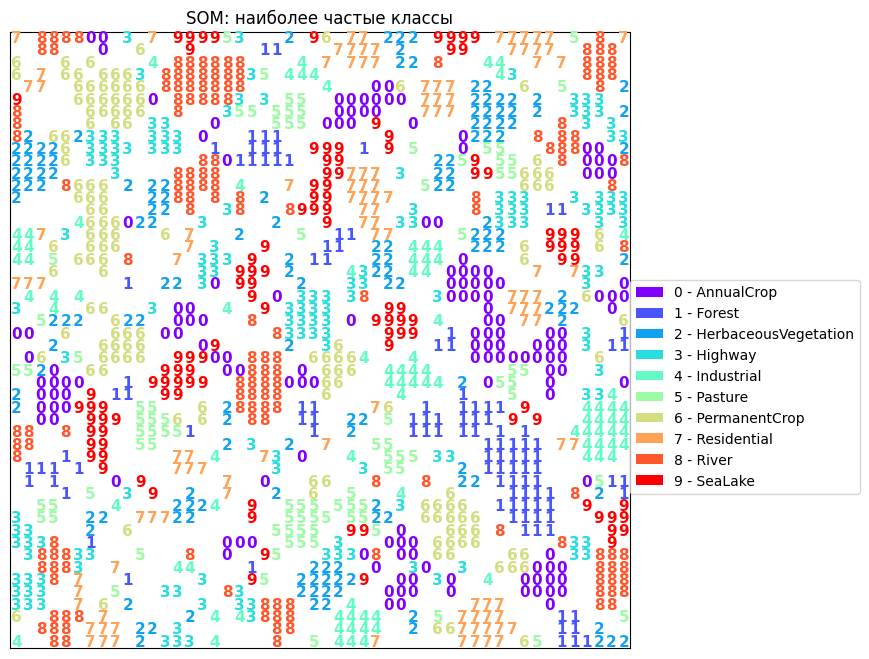

In [116]:
with open(Path(img_path) / 'label_map.json', 'r') as fp:
    labels_dict = json.load(fp)

plot_som_legend_full(
    som=som,
    embeddings=embeddings_train,
    labels=labels_train,
    class_names=labels_dict,
    save_path="../resulting_images/som_classes_legend_50x50_on_train.png"
)

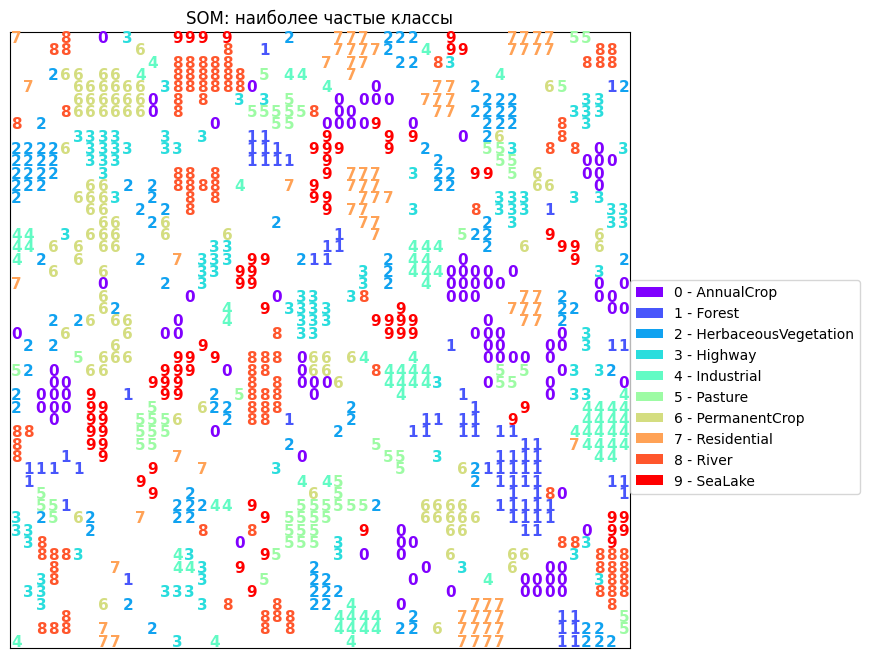

In [117]:
plot_som_legend_full(
    som=som,
    embeddings=embeddings_test,
    labels=labels_test,
    class_names=labels_dict,
    save_path="../resulting_images/som_classes_legend_50x50_on_test.png"
)